# Progetto rete neurale - Classificazione stelle

## Import Dataset

Importiamo le librerie base.

In [22]:
import numpy as np 
import pandas as pd 
from tqdm import tqdm
import matplotlib.pyplot as plt


Importiamo il dataset, composto da 240 esempi.
Ciascun esempio è descritto da 6 feature diverse (Temperatura assoluta [K], Luminosità relativa [] , Raggio relativo [], Magnitudine assoluta [], Colore [], Classe spettrale []) con associato il tipo di stella tra 6 classi diverse (Brown Dwarf, Red Dwarf, White Dwarf, Main Sequence, Supergiant, Hypergiant).

In [23]:
dt= pd.read_csv("Stars.csv")
dt.head()

,Temperature,L,R,A_M,Color,Spectral_Class,Type
0,3068,0.002400,0.1700,16.12,Red,M,0
1,3042,0.000500,0.1542,16.60,Red,M,0
2,2600,0.000300,0.1020,18.70,Red,M,0
3,2800,0.000200,0.1600,16.65,Red,M,0
4,1939,0.000138,0.1030,20.06,Red,M,0


Passiamo al primo check da fare, controlliamo la distribuzione degli esempi nelle vari classi(labels).

100%|██████████████████████████████████████████████████████████████████████████████████| 6/6 [00:00<00:00, 1998.72it/s]


Text(0, 0.5, '# of examples')

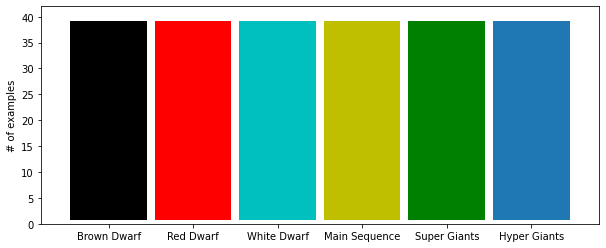

In [24]:
#creiamo dizionario associando a numeri nome classe

mydict = {0:"Brown Dwarf",1: "Red Dwarf", 2: "White Dwarf", 3: "Main Sequence"
          , 4: "Super Giants", 5: "Hyper Giants"}

for i in tqdm(range(len(mydict.keys()))):
    dt["Type"]=dt["Type"].replace(i,mydict[i])    
col = ["k","r","c","y","g", "b"]

fig, ax = plt.subplots(figsize = (10,4))

N, bins, patches = ax.hist(dt["Type"],bins=np.arange(0,7)-.5, edgecolor='white', linewidth=8, align="mid")

#settiamo colore diverse ad ogni classe

for i in range(len(col)-1):
    patches[i].set_facecolor(col[i])
ax.set_ylabel("# of examples",)

Il dataset è equamente diviso nelle 6 classi(40 esempi per ogni classe), ora passiamo a graficare la distribuzione degli esempi in funzione delle features numeriche(Temperatura assoluta [K], Luminosità relativa [] , Raggio relativo [], Magnitudine assoluta []).

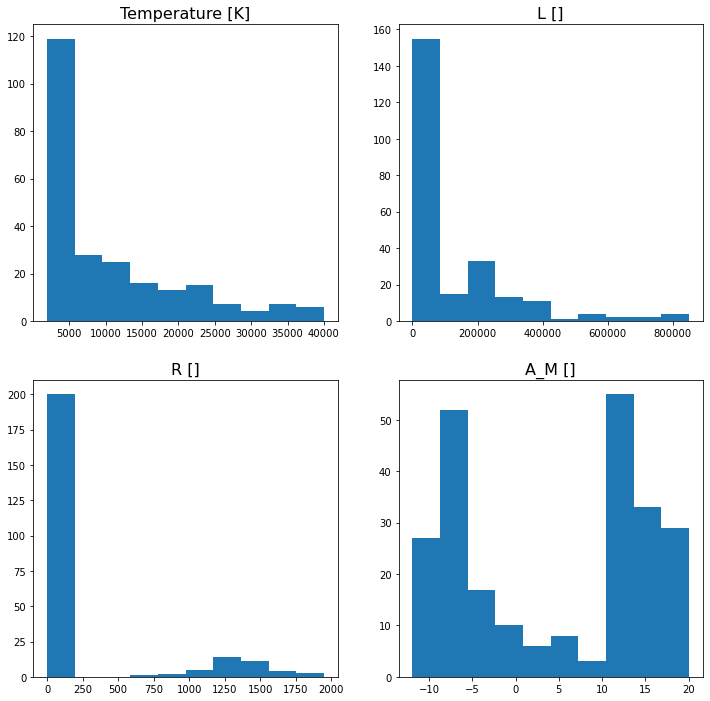

In [25]:
fig, axs = plt.subplots(2,2, figsize = (12,12))
meas_unit = ['[K]', '[]', '[]', '[]']

for i,key in enumerate(dt.keys()):
    if  i <=3:
        ax = axs.ravel()[i]
        ax.hist(dt[key])
        ax.set_title(f"{key} {meas_unit[i]}", fontsize = 16)
    else:
        continue

Sarà in seguito necessario riscalare le features perchè vi sono alcuni valori molto più frequenti di altri sopratutto agli estremi delle distribuzioni.
Inoltre nessuna delle feature mostra una distribuzione normale, motivo per cui dovremo vedere che processo di scaling è il più opportuno.

Importiamo ora da sklearn tutto ciò che ci servirà in seguito.

In [26]:
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, RobustScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras

## Pre-processing dati

Verifichiamo dimensioni dataset e distinguiamo tra features e labels.

In [27]:
print(dt.keys())
print('\n',dt.shape)

Index(['Temperature', 'L', 'R', 'A_M', 'Color', 'Spectral_Class', 'Type'], dtype='object')

 (240, 7)


In [28]:
#divido features da labels

y = dt[["Type"]]
X = dt.drop(["Type"], axis=1)
n_classes = len(y.Type.unique())

print(f"Dimensioni X sono :{X.shape}\ndimensioni y sono :{y.shape}")
print(f"Numero labels diverse:{n_classes}")

Dimensioni X sono :(240, 6)
dimensioni y sono :(240, 1)
Numero labels diverse:6


Processiamo i dati categoriali con il dummy encoding.

In [29]:
#implemento dummy encoding

X_col = X[["Color"]]
X_col = pd.get_dummies(X_col)
X_SC = X[["Spectral_Class"]]
X_SC = pd.get_dummies(X_SC)

#aggiungo alla feature matrix

X = pd.concat([X, X_col], axis=1)
X = pd.concat([X, X_SC], axis=1)
X = X.drop(["Color", "Spectral_Class"], axis=1)

Procediamo ora con il dividere il dataset in train, validation e test set, usando funzioni di sklearn.

In [30]:
test_size = .15
val_size = 0.30
X_train, X_test , y_train, y_test = train_test_split(X, y, test_size = test_size, stratify = y)
X_train, X_val , y_train, y_val = train_test_split(X_train, y_train, test_size = val_size, stratify = y_train)
print(f"Test set:\ndimensioni X sono :{X_test.shape}\ndimensioni y sono :{y_test.shape}\n\nTrain set:\ndimensioni X sono :{X_train.shape}\ndimensioni y sono :{y_train.shape}\n\nValidation set:\ndimensioni X sono :{X_val.shape}\ndimensioni y sono :{y_val.shape}\n")

Test set:
dimensioni X sono :(36, 28)
dimensioni y sono :(36, 1)

Train set:
dimensioni X sono :(142, 28)
dimensioni y sono :(142, 1)

Validation set:
dimensioni X sono :(62, 28)
dimensioni y sono :(62, 1)



Possiamo ora implementare lo scaling delle features numeriche, definiamo una funzione generica in modo da poterne provare diversi tipi.

In [31]:
#facciamo copia dei dati, in modo da poter fare più scaling

X_train_nor , X_val_nor, X_test_nor = X_train.copy(), X_val.copy(), X_test.copy()

#definiamo funzione generica

def norm(X, scaler_type, n):
    scalers = {}
    for i, key in enumerate(X):
        if i <= n:
            scaler = scaler_type
            X[[key]] = scaler.fit_transform(X[[key]])
            scalers[i] = scaler
    return scalers

#proviamo il MinMaxScaler
scaler_train = norm(X_train_nor, MinMaxScaler() ,3)
scaler_test = norm(X_test_nor, MinMaxScaler(), 3)
scaler_val = norm(X_val_nor, MinMaxScaler(),  3)

Convertiamo ora le labels con il OneHotEncoding, che è più utile al nostro scopo di classificazione multiclasse.

In [32]:
enc = OneHotEncoder()

#labels di train

encoders = {}
enc.fit(y_train)
y_train_cat = enc.transform(y_train).toarray()
encoders[0] = enc

#labels di validation

enc.fit(y_val)
y_val_cat = enc.transform(y_val).toarray()
encoders[1] = enc

#labels di test

enc.fit(y_train)
y_test_cat = enc.transform(y_test).toarray()
encoders[2] = enc

Infine convertiamo gli esempi in numpy arrays, che la rete può utilizzare.

In [33]:
X_train_nor = X_train_nor.to_numpy()
X_val_nor = X_val_nor.to_numpy()
X_test_nor = X_test_nor.to_numpy()


## Definizione struttura rete

Passiamo ora al definire la struttura della nostra rete neurale, useremo la libreria keras, di cui importeremo diversi moduli.

In [34]:
#importiamo tipo modello 

from tensorflow.keras.models import Sequential

#import unico tipo di layer che useremo

from tensorflow.keras.layers import Dense


In [35]:
#creazione della struttura

keras.backend.clear_session()

model = Sequential()
model.add(Dense(15, input_shape=(28,), kernel_initializer='he_normal', bias_initializer='zeros', activation='relu')) #15 hidden units with relu activation
model.add(Dense(n_classes, activation='softmax')) #output layer with softmax activations

In [36]:
#check della struttura

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 15)                435       
                                                                 
 dense_1 (Dense)             (None, 6)                 96        
                                                                 
Total params: 531
Trainable params: 531
Non-trainable params: 0
_________________________________________________________________


In [37]:
#salviamo i pesi iniziali, nel caso volessimo fare più train del modello con iperparametri diversi

model.save_weights('model.h5')

In [38]:
#definisco gli iperparametri 

epochs = 100
batch_size = 25


## Training rete

Cominciamo ora a trainare la rete neurale.

In [39]:
#compiliamo il modello, useremo in questo caso lo Stochastic Gradient Descend

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = .05), metrics=['accuracy'])

#facciamo il fit 

history = model.fit(X_train_nor, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nor,y_val_cat), verbose=1, shuffle=True)

Epoch 1/100
6/6 [==============================] - 0s 31ms/step - loss: 1.7905 - accuracy: 0.1972 - val_loss: 1.7844 - val_accuracy: 0.2581
Epoch 2/100
6/6 [==============================] - 0s 9ms/step - loss: 1.7415 - accuracy: 0.2183 - val_loss: 1.7393 - val_accuracy: 0.2742
Epoch 3/100
6/6 [==============================] - 0s 10ms/step - loss: 1.6971 - accuracy: 0.2887 - val_loss: 1.6988 - val_accuracy: 0.2419
Epoch 4/100
6/6 [==============================] - 0s 10ms/step - loss: 1.6588 - accuracy: 0.1972 - val_loss: 1.6621 - val_accuracy: 0.2581
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 1.6227 - accuracy: 0.2676 - val_loss: 1.6275 - val_accuracy: 0.2742
Epoch 6/100
6/6 [==============================] - 0s 9ms/step - loss: 1.5901 - accuracy: 0.3099 - val_loss: 1.5959 - val_accuracy: 0.3226
Epoch 7/100
6/6 [==============================] - 0s 11ms/step - loss: 1.5589 - accuracy: 0.3662 - val_loss: 1.5656 - val_accuracy: 0.3871
Epoch 8/100
6/6 [======

6/6 [==============================] - 0s 7ms/step - loss: 0.6054 - accuracy: 0.7535 - val_loss: 0.6769 - val_accuracy: 0.7258
Epoch 60/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5965 - accuracy: 0.7535 - val_loss: 0.6710 - val_accuracy: 0.7258
Epoch 61/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5911 - accuracy: 0.7535 - val_loss: 0.6649 - val_accuracy: 0.7258
Epoch 62/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5851 - accuracy: 0.8099 - val_loss: 0.6606 - val_accuracy: 0.7258
Epoch 63/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5784 - accuracy: 0.7746 - val_loss: 0.6565 - val_accuracy: 0.7258
Epoch 64/100
6/6 [==============================] - 0s 8ms/step - loss: 0.5716 - accuracy: 0.7535 - val_loss: 0.6493 - val_accuracy: 0.7258
Epoch 65/100
6/6 [==============================] - 0s 7ms/step - loss: 0.5643 - accuracy: 0.7535 - val_loss: 0.6433 - val_accuracy: 0.7258
Epoch 66/100
6/6 [===============

Verifichiamo con il test set come si comporta il modello con nuovi dati.

In [40]:
test_loss, test_acc = model.evaluate(X_test_nor, y_test_cat)

print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

2/2 [==============================] - 0s 5ms/step - loss: 0.4147 - accuracy: 0.7778
Test Loss:	 0.414668470621109
Test Accuracy:	 0.7777777910232544


Valutiamo ora le learning curves, in modo da studiare eventuali problemi del modello.

Text(0.5, 1.0, 'Learning curves(SGD) - MinMaxScaling')

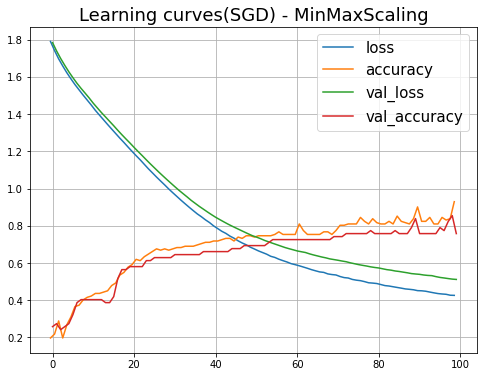

In [41]:
fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()


ax.legend(fontsize=15);
ax.set_title("Learning curves(SGD) - MinMaxScaling", fontsize = 18)

Sebbene sia l'accuracy che la loss del modello sul test set siano buone, è chiaro dalle learning curves che c'è un problema non dovuto al learning rate (accuracy oscilla mentre la loss tende ad avere il giusto trend).

Proviamo dunque a cambiare lo scaling dei dati e ri-trainare il modello, usiamo il RobustScaling, visto che dalla distribuzione dei dati si evincevano valori molto più frequenti di altri.

In [42]:
#facciamo ancora una copia dei dati 

X_train_nor , X_val_nor, X_test_nor = X_train.copy(), X_val.copy(), X_test.copy()

#proviamo il RobustScaler
scaler_train = norm(X_train_nor, RobustScaler() ,3)
scaler_test = norm(X_test_nor, RobustScaler(), 3)
scaler_val = norm(X_val_nor, RobustScaler(),  3)

Convertiamo in numpy arrays.


In [43]:
X_train_nor = X_train_nor.to_numpy()
X_val_nor = X_val_nor.to_numpy()
X_test_nor = X_test_nor.to_numpy()


Dobbiamo ora resettare i pesi che avevamo inizializzato, dunque usiamo la copia fatta inizialmente e facciamo altro train.

In [45]:
model.load_weights('model.h5')

#compiliamo il modello, useremo ancora Stochastic Gradient Descend

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.SGD(learning_rate = .05), metrics=['accuracy'])

#facciamo il fit 

history = model.fit(X_train_nor, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nor,y_val_cat), verbose=0, shuffle=True);

Valutiamo performance sul test set in questo caso.

In [27]:
test_loss, test_acc = model.evaluate(X_test_nor, y_test_cat)

print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

2/2 [==============================] - 0s 4ms/step - loss: 0.3068 - accuracy: 0.9444
Test Loss:	 0.3068050146102905
Test Accuracy:	 0.9444444179534912


Grafichiamo le learning curves.

Text(0.5, 1.0, 'Learning curves(SGD) - RobustScaling')

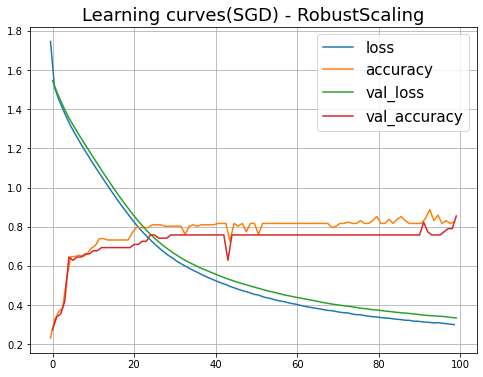

In [28]:
fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=15);
ax.set_title("Learning curves(SGD) - RobustScaling", fontsize = 18)

In [29]:
fig.savefig("Learning curves(SGD) - RobustScaling.jpg",bbox_inches='tight', dpi=150)

Ancora una volta le performance sono buone, ma l'andamento dell'accuracy è molto oscillante, sebbene sia chiaro che con questo scaling sia migliore.

A questo punto per rimuovere oscillazioni proviamo a cambiare l'algoritmo di ottimizzazione, usando l'Adam optimizer, che potrebbe essere più consistente utilizzando adattamenti su learning rate di parametri diversi.

Procediamo ancora una volta a caricare i pesi iniziali, in modo da poter tornare a fare train.

In [35]:
model.load_weights("model.h5")

#modifichiamo iperparametro di learning rate, perchè Adam raggiunge convergenza più velocemente

l_r = 0.004

#compiliamo il modello, useremo questo volta Adam

model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.Adam(learning_rate = l_r), metrics=['accuracy'])

#facciamo il fit 

history = model.fit(X_train_nor, y_train_cat, epochs=epochs, batch_size=batch_size, validation_data=(X_val_nor,y_val_cat), verbose=1, shuffle=True)

Epoch 1/100
6/6 [==============================] - 0s 26ms/step - loss: 5.1836 - accuracy: 0.1479 - val_loss: 4.7144 - val_accuracy: 0.1774
Epoch 2/100
6/6 [==============================] - 0s 10ms/step - loss: 4.4719 - accuracy: 0.2394 - val_loss: 4.0065 - val_accuracy: 0.2419
Epoch 3/100
6/6 [==============================] - 0s 8ms/step - loss: 3.6938 - accuracy: 0.2676 - val_loss: 3.2960 - val_accuracy: 0.2581
Epoch 4/100
6/6 [==============================] - 0s 7ms/step - loss: 2.9385 - accuracy: 0.2746 - val_loss: 2.5435 - val_accuracy: 0.2742
Epoch 5/100
6/6 [==============================] - 0s 9ms/step - loss: 2.1702 - accuracy: 0.3662 - val_loss: 1.7866 - val_accuracy: 0.4516
Epoch 6/100
6/6 [==============================] - 0s 7ms/step - loss: 1.4792 - accuracy: 0.5634 - val_loss: 1.2883 - val_accuracy: 0.6452
Epoch 7/100
6/6 [==============================] - 0s 8ms/step - loss: 1.1469 - accuracy: 0.7324 - val_loss: 1.1714 - val_accuracy: 0.6613
Epoch 8/100
6/6 [========

Valutiamo performance nuovo training.

In [36]:
test_loss, test_acc = model.evaluate(X_test_nor, y_test_cat)

print('Test Loss:\t', test_loss)
print('Test Accuracy:\t', test_acc)

2/2 [==============================] - 0s 4ms/step - loss: 0.0890 - accuracy: 0.9722
Test Loss:	 0.08896240592002869
Test Accuracy:	 0.9722222089767456


Grafichiamo ancora una volta.

Text(0.5, 1.0, 'Learning curves(Adam) - RobustScaling')

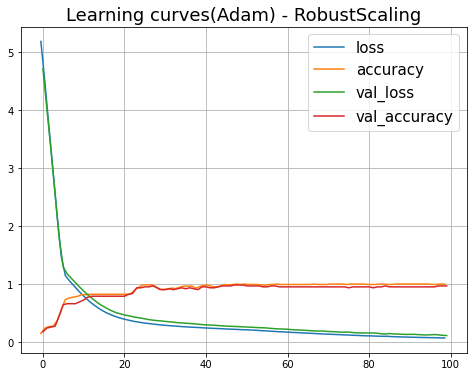

In [37]:
fig, ax = plt.subplots(figsize=(8,6))

for metric in history.history:
    if len(metric.split('_')) < 2:
        ax.plot(np.array(history.epoch)-.5, history.history[metric], label=metric)
    else:
        ax.plot(history.epoch, history.history[metric], label=metric)
    
ax.grid()    

ax.legend(fontsize=15);
ax.set_title("Learning curves(Adam) - RobustScaling", fontsize = 18)

Questa volta ci soddisfano sia le performance sul test set che le learning curves, che hanno molte meno oscillazioni.